In [ ]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 6.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import json
import pandas as pd
import glob
import statistics as stat
import statsmodels.tsa.stattools as smt
from scipy import signal # lag detection
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import calendar, time, datetime
from bs4 import BeautifulSoup
from datetime import datetime as dt
import requests
import tarfile
from google.colab import files
import os
import shutil
import inspect

In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [ ]:
def get_csv(price_ticker, element_list, url, i): #i is page number
  file_name = element_list[i].get_text()

  ticker_dir = price_ticker[:-3] + '_data'
  data_path = ticker_dir + '/' + file_name

  my_cwd = os.getcwd()
  path = os.path.join(my_cwd, ticker_dir)
  os.mkdir(path)

  download_url = url + file_name
  response = requests.get(download_url)

  with open(data_path, 'wb') as file:
      file.write(response.content)

  df = pd.read_csv(data_path, compression='gzip', header=0, sep=',', quotechar='"')
  print(df.shape[0])
  shutil.rmtree(ticker_dir)

  return df

In [ ]:
def all_csv(price_ticker, start, end): # download all period and return dataframe
  url = 'https://public.bybit.com/spot_index/' + price_ticker + '/'
  page = requests.get(url)
  soup = BeautifulSoup(page.text, "html.parser")
  element_list = soup.find_all('a')

  df_all = pd.DataFrame()

  start = calendar.timegm(time.strptime(start, '%Y-%m-%d %H:%M:%S'))
  end = calendar.timegm(time.strptime(end, '%Y-%m-%d %H:%M:%S'))

  for i in range(len(element_list)):
    i_data = element_list[i].get_text()[6:16] + ' 00:00:00'
    i_data = calendar.timegm(time.strptime(i_data, '%Y-%m-%d %H:%M:%S'))
    if i_data >= start and i_data <= end:
      df_all = pd.concat([df_all,get_csv(price_ticker, element_list, url, i)], ignore_index=True)

  df_all = df_all.loc[df_all[ 'start_at'] <= end]
  df_all = df_all.loc[df_all['start_at'] >= start]
  df_all = df_all[['start_at', 'close']]
  return df_all

In [ ]:
def all_data(start, end):
  url_tickers = 'https://public.bybit.com/spot_index/'
  page = requests.get(url_tickers)

  soup = BeautifulSoup(page.text, "html.parser")
  element_list = soup.find_all('a')

  price_tickers = []
  for element in element_list:
    price_tickers.append(element.get_text()[:-1])

  df = all_csv('BTCUSD', start, end)
  for i in range(0, len(price_tickers)):
    if ( 'ETHUSD'== price_tickers[i] or 'SOLUSD'== price_tickers[i] or 'XRPUSD'== price_tickers[i] ):
      df_iter = all_csv(price_tickers[i][:3], start, end)
      suffixes = ['_BTC' ]
      suffixes = suffixes.append('close_' + all_tickers[i][:3])
      df = df.merge(df_iter, on = 'start_at', suffixes=(all_tickers[i] , all_tickers[i]))
  df = df.set_axis(['start_at', suffixes], axis=1)

In [ ]:
url_tickers = 'https://public.bybit.com/spot_index/'
page = requests.get(url_tickers)

In [ ]:
start = input("Введите дату и время начала периода в формате Y-m-d H:M:S :")
end = input("Введите дату и время конца периода в формате Y-m-d H:M:S :")

Введите дату и время начала периода в формате Y-m-d H:M:S :2024-06-01 00:00:00
Введите дату и время конца периода в формате Y-m-d H:M:S :2024-09-01 00:00:00


In [ ]:
soup = BeautifulSoup(page.text, "html.parser")
element_list = soup.find_all('a')
element_list

[<a href="ADAUSD/">ADAUSD/</a>,
 <a href="BITUSD/">BITUSD/</a>,
 <a href="BTCUSD/">BTCUSD/</a>,
 <a href="DOTUSD/">DOTUSD/</a>,
 <a href="EOSUSD/">EOSUSD/</a>,
 <a href="ETHUSD/">ETHUSD/</a>,
 <a href="LTCUSD/">LTCUSD/</a>,
 <a href="LUNAUSD/">LUNAUSD/</a>,
 <a href="MANAUSD/">MANAUSD/</a>,
 <a href="SOLUSD/">SOLUSD/</a>,
 <a href="XRPUSD/">XRPUSD/</a>]

In [ ]:
price_tickers = []
for element in element_list:
  price_tickers.append(element.get_text()[:-1])

for i in price_tickers:
  if i == 'BITUSD' or i == 'LUNAUSD' or i == 'MANAUSD':
    price_tickers.remove(i)
price_tickers.remove('MANAUSD')
price_tickers

['ADAUSD',
 'BTCUSD',
 'DOTUSD',
 'EOSUSD',
 'ETHUSD',
 'LTCUSD',
 'SOLUSD',
 'XRPUSD']

In [ ]:
# выше есть функция которая парсит сразу все тикеры, а тут руками
BTC_data = all_csv('BTCUSD',start,end)
ETH_data = all_csv('ETHUSD',start,end)
SOL_data = all_csv('SOLUSD',start,end)
XRP_data = all_csv('XRPUSD',start,end)


1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440
1440


In [ ]:
#all_tickers_data = [ADA_data, DOT_data, EOS_data, ETH_data, LTC_data, SOL_data, XRP_data]
all_tickers_data = [ETH_data, SOL_data, XRP_data]
type(all_tickers_data[1])
all_tickers = ['BTC', 'ETH', 'SOL', 'XRP']

In [ ]:
all_data_via_tickers = BTC_data
for i in range(0, len(all_tickers_data)):
  x = all_tickers_data[i]
  all_data_via_tickers = all_data_via_tickers.merge(x, on='start_at', suffixes=(all_tickers[i] , all_tickers[i]))
all_data_via_tickers = all_data_via_tickers.set_axis(['start_at', 'closeBTC', 'closeETH', 'closeSOL','closeXRP'], axis=1)


In [ ]:
# Можно переписать вместо цикла df.C = df.A + df.B
all_data_via_tickers['start_time'] = ""
for i in range (0, len(all_data_via_tickers['start_at'])):
  all_data_via_tickers['start_time'][i] = datetime.datetime.fromtimestamp(all_data_via_tickers['start_at'][i])

Streaming output truncated to the last 5000 lines.
<ipython-input-19-093e9404fd8e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_via_tickers['start_time'][i] = datetime.datetime.fromtimestamp(all_data_via_tickers['start_at'][i])
<ipython-input-19-093e9404fd8e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_via_tickers['start_time'][i] = datetime.datetime.fromtimestamp(all_data_via_tickers['start_at'][i])
<ipython-input-19-093e9404fd8e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [ ]:
del all_data_via_tickers['start_at']
all_data_time = all_data_via_tickers.set_index('start_time')

,closeBTC,closeETH,closeSOL,closeXRP
start_time,,,,
2024-06-01 00:00:00,67504.89,3762.06,165.60,0.5172
2024-06-01 00:01:00,67497.91,3759.41,165.56,0.5170
2024-06-01 00:02:00,67513.35,3760.86,165.77,0.5174
2024-06-01 00:03:00,67536.36,3761.97,165.81,0.5175
2024-06-01 00:04:00,67578.63,3762.97,165.90,0.5177
...,...,...,...,...
2024-08-31 23:56:00,58991.55,2514.45,135.41,0.5664
2024-08-31 23:57:00,58988.53,2513.69,135.38,0.5663
2024-08-31 23:58:00,58990.18,2514.13,135.38,0.5663


In [ ]:
all_data_pct = all_data_time.pct_change() # таблица с отклонением от предыдущей цены закрытия
#all_data_pct = all_data_pct.dropna()
all_data_pct = all_data_pct.dropna() # удаляем первую строку

Text(0.5, 1.0, 'BTC')

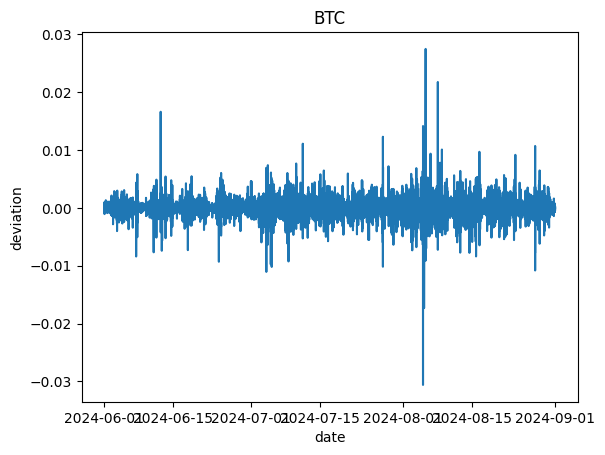

In [ ]:
plt.plot(all_data_pct['closeBTC'])
plt.xlabel('date')
plt.ylabel('deviation')
plt.title('BTC')

Text(0.5, 1.0, 'ETH')

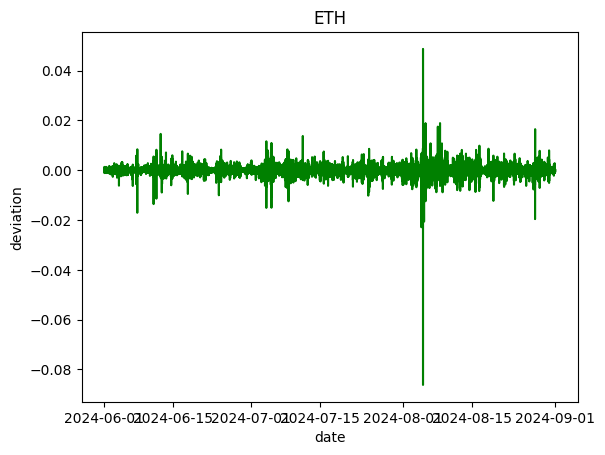

In [ ]:
plt.plot(all_data_pct['closeETH'],'g')
plt.xlabel('date')
plt.ylabel('deviation')
plt.title('ETH')

Text(0.5, 1.0, 'SOL')

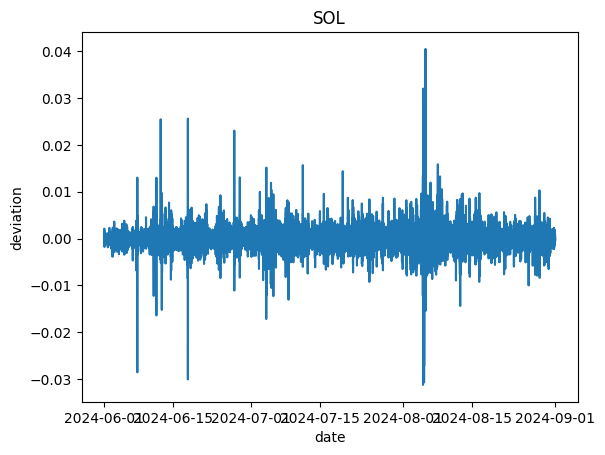

In [ ]:
plt.plot(all_data_pct['closeSOL'])
plt.xlabel('date')
plt.ylabel('deviation')
plt.title('SOL')

Text(0.5, 1.0, 'XRP')

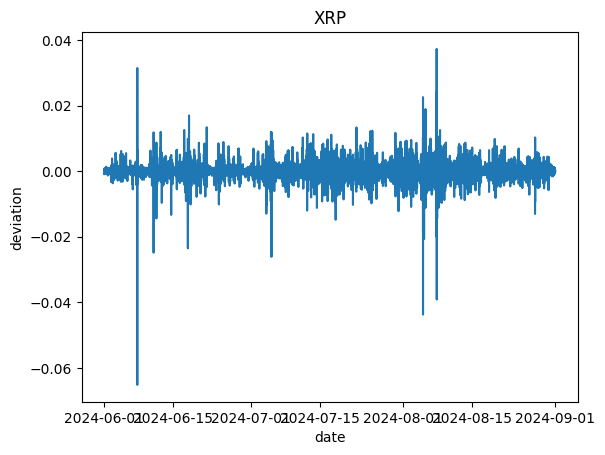

In [ ]:
plt.plot(all_data_pct['closeXRP'])
plt.xlabel('date')
plt.ylabel('deviation')
plt.title('XRP')

In [ ]:
# таблица корреляций
all_data_pct.corr()

,closeBTC,closeETH,closeSOL,closeXRP
closeBTC,1.000000,0.822334,0.745518,0.534564
closeETH,0.822334,1.000000,0.748424,0.578629
closeSOL,0.745518,0.748424,1.000000,0.564938
closeXRP,0.534564,0.578629,0.564938,1.000000


In [ ]:
# корреляционная матрица для каждых 30-ти минут
roll_corr = all_data_pct.rolling(30).corr()
roll_corr.dropna()

closeBTC  closeETH  closeSOL  closeXRP
start_time                                                          
2024-06-01 00:30:00 closeBTC  1.000000  0.772681  0.612009  0.462302
                    closeETH  0.772681  1.000000  0.779099  0.563866
                    closeSOL  0.612009  0.779099  1.000000  0.542091
                    closeXRP  0.462302  0.563866  0.542091  1.000000
2024-06-01 00:31:00 closeBTC  1.000000  0.801281  0.591595  0.461429
...                                ...       ...       ...       ...
2024-08-31 23:59:00 closeXRP  0.264868  0.348352  0.314272  1.000000
2024-09-01 00:00:00 closeBTC  1.000000  0.799261  0.786521  0.276486
                    closeETH  0.799261  1.000000  0.870278  0.357541
                    closeSOL  0.786521  0.870278  1.000000  0.349784
                    closeXRP  0.276486  0.357541  0.349784  1.000000

[529804 rows x 4 columns]

In [ ]:
correlations = roll_corr.unstack().dropna()

In [ ]:
correlations

closeBTC                                closeETH           \
                    closeBTC  closeETH  closeSOL  closeXRP  closeBTC closeETH   
start_time                                                                      
2024-06-01 00:30:00      1.0  0.772681  0.612009  0.462302  0.772681      1.0   
2024-06-01 00:31:00      1.0  0.801281  0.591595  0.461429  0.801281      1.0   
2024-06-01 00:32:00      1.0  0.781291  0.594601  0.451900  0.781291      1.0   
2024-06-01 00:33:00      1.0  0.775568  0.599856  0.429239  0.775568      1.0   
2024-06-01 00:34:00      1.0  0.793621  0.552428  0.376864  0.793621      1.0   
...                      ...       ...       ...       ...       ...      ...   
2024-08-31 23:56:00      1.0  0.793293  0.800968  0.324755  0.793293      1.0   
2024-08-31 23:57:00      1.0  0.791611  0.796680  0.296116  0.791611      1.0   
2024-08-31 23:58:00      1.0  0.788492  0.794004  0.296331  0.788492      1.0   
2024-08-31 23:59:00      1.0  0.797630  0.788714  0.264868  0.797630      1.0   
2024-09-01 00:00:00      1.0  0.799261  0.786521  0.276486  0.799261      1.0   

                                         closeSOL                     \
                     closeSOL  closeXRP  closeBTC  closeETH closeSOL   
start_time                                                             
2024-06-01 00:30:00  0.779099  0.563866  0.612009  0.779099      1.0   
2024-06-01 00:31:00  0.781285  0.537224  0.591595  0.781285      1.0   
2024-06-01 00:32:00  0.757829  0.501379  0.594601  0.757829      1.0   
2024-06-01 00:33:00  0.761449  0.464019  0.599856  0.761449      1.0   
2024-06-01 00:34:00  0.732358  0.443966  0.552428  0.732358      1.0   
...                       ...       ...       ...       ...      ...   
2024-08-31 23:56:00  0.855479  0.343721  0.800968  0.855479      1.0   
2024-08-31 23:57:00  0.876179  0.368820  0.796680  0.876179      1.0   
2024-08-31 23:58:00  0.868565  0.367114  0.794004  0.868565      1.0   
2024-08-31 23:59:00  0.873869  0.348352  0.788714  0.873869      1.0   
2024-09-01 00:00:00  0.870278  0.357541  0.786521  0.870278      1.0   

                               closeXRP                               
                     closeXRP  closeBTC  closeETH  closeSOL closeXRP  
start_time                                                            
2024-06-01 00:30:00  0.542091  0.462302  0.563866  0.542091      1.0  
2024-06-01 00:31:00  0.531341  0.461429  0.537224  0.531341      1.0  
2024-06-01 00:32:00  0.456507  0.451900  0.501379  0.456507      1.0  
2024-06-01 00:33:00  0.437715  0.429239  0.464019  0.437715      1.0  
2024-06-01 00:34:00  0.417895  0.376864  0.443966  0.417895      1.0  
...                       ...       ...       ...       ...      ...  
2024-08-31 23:56:00  0.386763  0.324755  0.343721  0.386763      1.0  
2024-08-31 23:57:00  0.341079  0.296116  0.368820  0.341079      1.0  
2024-08-31 23:58:00  0.343253  0.296331  0.367114  0.343253      1.0  
2024-08-31 23:59:00  0.314272  0.264868  0.348352  0.314272      1.0  
2024-09-01 00:00:00  0.349784  0.276486  0.357541  0.349784      1.0  

[132451 rows x 16 columns]

In [ ]:
correlations['closeBTC']['closeETH'].mean()

0.8180993301342807

<Axes: xlabel='start_time'>

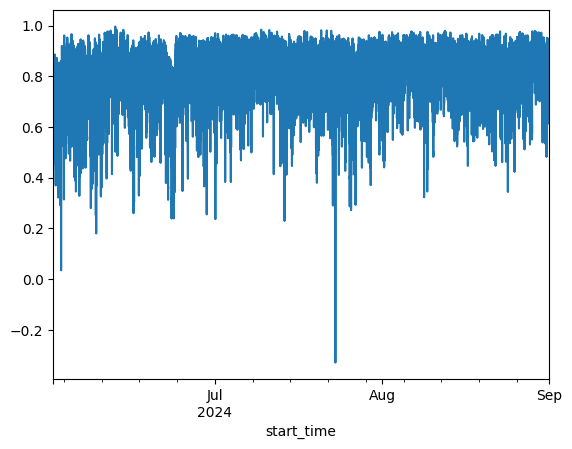

In [ ]:
correlations['closeBTC']['closeETH'].plot()

In [ ]:
ccr = signal.correlate(all_data_pct['closeBTC'], all_data_pct['closeSOL'], mode='same')
print(ccr)
lags = signal.correlation_lags(len(all_data_pct['closeBTC']), len(all_data_pct['closeSOL']), mode='same')
lags[np.argmax(ccr)]

[-3.59859503e-05 -2.09682486e-04  3.40404705e-04 ...  1.77661606e-04
  1.44329037e-04 -1.78141130e-04]


0

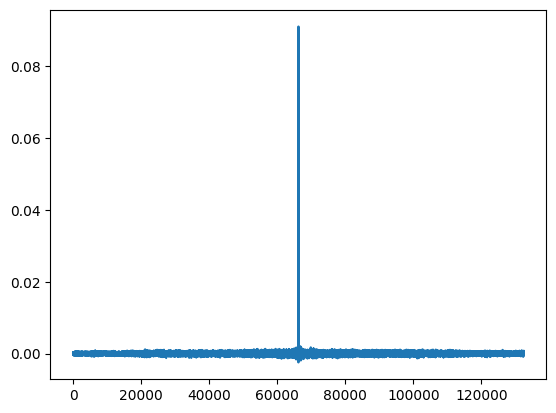

In [ ]:
plt.plot(ccr)

In [ ]:
np.argmax(ccr)

66240

In [ ]:
ccr[66240]

0.09107072698083793

In [ ]:
# тут по оси x две длины массива так как смотрели лаги в обе стороны
backwards = smt.ccf(all_data_pct['closeBTC'], all_data_pct['closeETH'], adjusted=False)[::-1]
forwards = smt.ccf(all_data_pct['closeBTC'], all_data_pct['closeETH'], adjusted=False)
ccf_output_ETH = np.r_[backwards[:-1], forwards]

backwards = smt.ccf(all_data_pct['closeBTC'], all_data_pct['closeETH'], adjusted=False)[::-1]
forwards = smt.ccf(all_data_pct['closeBTC'], all_data_pct['closeETH'], adjusted=False)
ccf_output_SOL = np.r_[backwards[:-1], forwards]

backwards = smt.ccf(all_data_pct['closeBTC'], all_data_pct['closeXRP'], adjusted=False)[::-1]
forwards = smt.ccf(all_data_pct['closeBTC'], all_data_pct['closeXRP'], adjusted=False)
ccf_output_XRP = np.r_[backwards[:-1], forwards]

Text(0.5, 1.0, 'BTC_ETH')

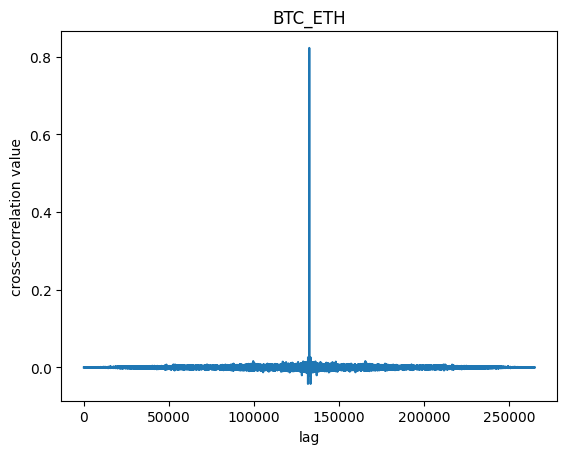

In [ ]:
plt.plot(ccf_output_ETH, label = 'BTC_ETH_ccf')
plt.xlabel('lag')
plt.ylabel('cross-correlation value')
plt.title('BTC_ETH')

Text(0.5, 1.0, 'BTC_SOL')

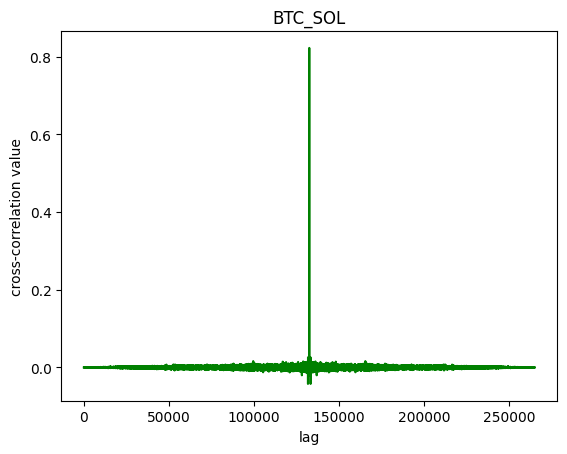

In [ ]:
plt.plot(ccf_output_SOL, 'g', label = 'BTC_SOL_ccf')
plt.xlabel('lag')
plt.ylabel('cross-correlation value')
plt.title('BTC_SOL')

Text(0.5, 1.0, 'BTC_XRP')

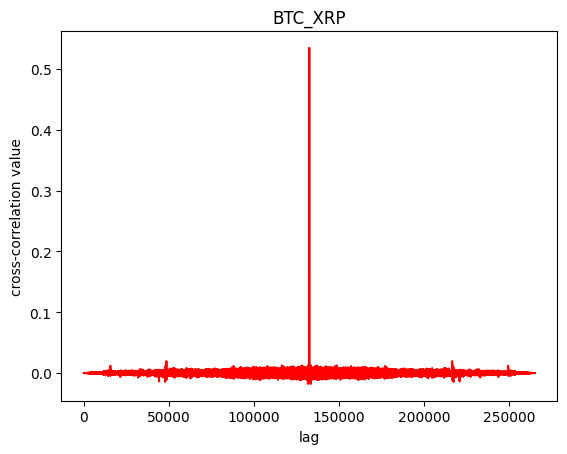

In [ ]:
# хоть тут корреляция и 0,5 один хер при нулевом лаге она максимальная
plt.plot(ccf_output_XRP, 'r',label = 'BTC_XRP_ccf')
plt.xlabel('lag')
plt.ylabel('cross-correlation value')
plt.title('BTC_XRP')

In [ ]:
#x = [10, 20, 30, 40, 50, 60]
x = {'A':[1, 2, 3], 'B': [4, 5, 6]}
df_x = pd.DataFrame(x)
df_x['C'] = ""
df_x['C'] = df_x.A + df_x.B
print(df_x['C'])
y = [1, 2, 3, 4, 5, 6]
#ccr = np.correlate(x, y, mode='full')
#ccr

0    5
1    7
2    9
Name: C, dtype: int64


Тут начинается самодеятельность с корреляцией




.






In [ ]:
#Писал сам корреляции считаем не по ценовым отклонениям а по абсолютным ценам
data = []
for i in range(0,len(all_tickers_data)):
  data.append(pd.merge(BTC_data, all_tickers_data[i], on='start_at'))
  del data[i]['start_at']
  print('Bitcoin correlation with ',retrieve_name(all_tickers_data[i]),' = ', data[i].corr()['close_y'].iloc[0])


Bitcoin correlation with  ['ETH_data']  =  0.7731546196510681
Bitcoin correlation with  ['SOL_data']  =  0.7068335804841283
Bitcoin correlation with  ['XRP_data']  =  0.21588544938029067


In [ ]:
#Fix some warnings How to optimize this part?
#Добавляем новый столбец с датами
BTC_data['start_time'] = ""
for i in range (0, len(BTC_data['close'])):
  BTC_data['start_time'][i] = datetime.datetime.fromtimestamp(BTC_data['start_at'][i])

SOL_data['start_time'] = ""
for i in range (0, len(SOL_data['close'])):
  SOL_data['start_time'][i] = datetime.datetime.fromtimestamp(SOL_data['start_at'][i])

Streaming output truncated to the last 5000 lines.
<ipython-input-104-2a4c0d03a0f5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOL_data['start_time'][i] = datetime.datetime.fromtimestamp(SOL_data['start_at'][i])
<ipython-input-104-2a4c0d03a0f5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOL_data['start_time'][i] = datetime.datetime.fromtimestamp(SOL_data['start_at'][i])
<ipython-input-104-2a4c0d03a0f5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [ ]:
# New dataframe for convinience
# новый датафрейм в котором даты это индексы
BTC_data_time = pd.DataFrame({'start_time': BTC_data['start_time'], 'close': BTC_data['close']}).set_index('start_time')

SOL_data_time = pd.DataFrame({'start_time': SOL_data['start_time'], 'close': SOL_data['close']}).set_index('start_time')

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='close'>)

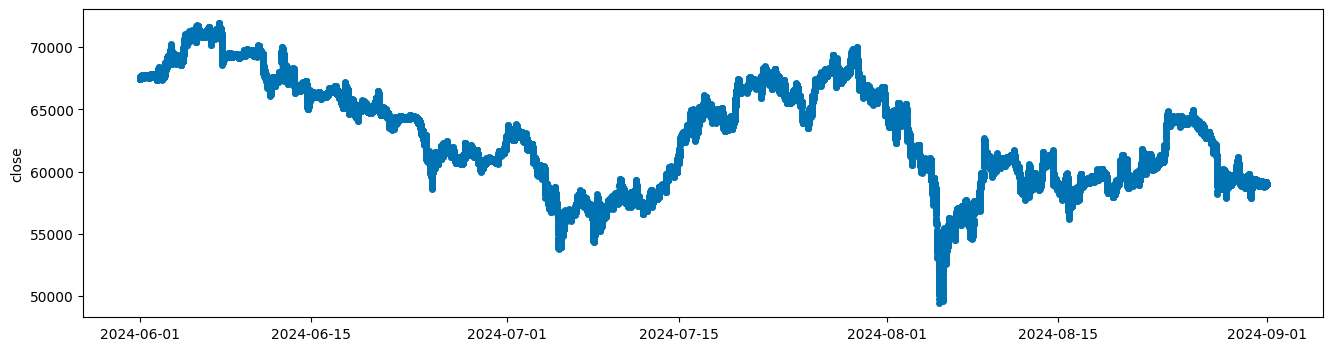

In [ ]:
from sktime.utils.plotting import plot_series

#plot_series(BTC_data_time.close, SOL_data_time.close, labels = ['BTC','SOL'])
plot_series(BTC_data_time.close)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='close'>)

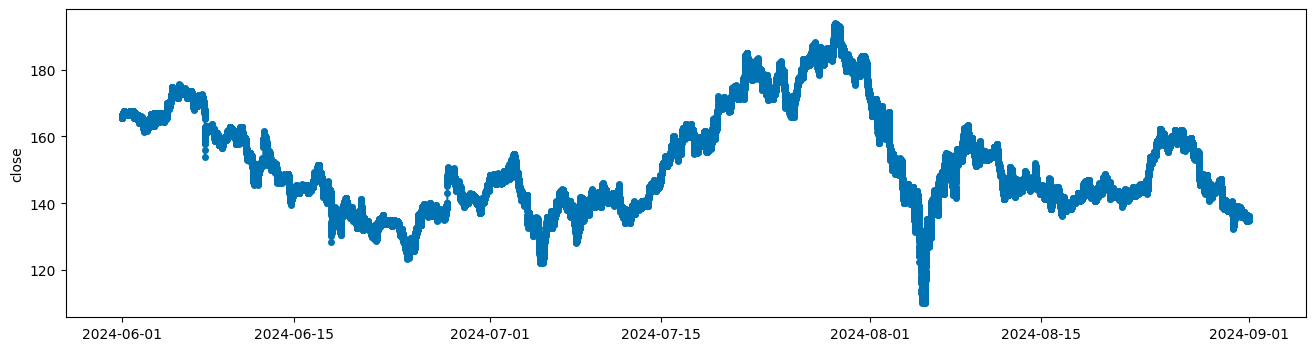

In [ ]:
from sktime.utils.plotting import plot_series

#plot_series(BTC_data_time.close, SOL_data_time.close, labels = ['BTC','SOL'])
plot_series(SOL_data_time.close)

Тут заканчивается самодеятельность с корреляцией

In [ ]:
# Тут хрень
correlation = signal.correlate(BTC_data['close'], SOL_data['close'], mode="full")
lags = signal.correlation_lags(len(BTC_data['close']), len(ETH_data['close']), mode="full")
lag = lags[np.argmax(correlation)]

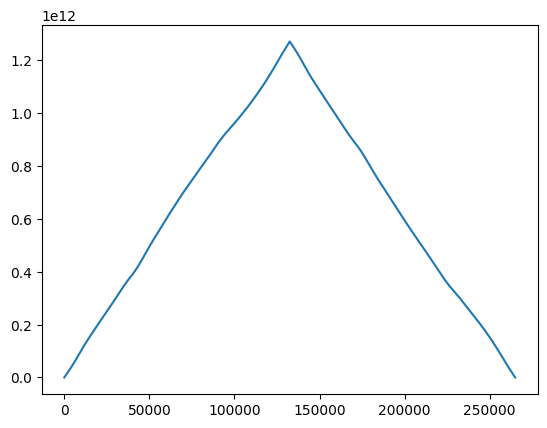

In [ ]:
plt.plot(correlation)